In [6]:
import os
import json
import re
import pandas as pd

RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
MODEL_NAME = "UNet_ACDC"  # change if needed


def _read_json(path: str) -> dict | None:
    if not os.path.isfile(path):
        return None
    with open(path, "r") as f:
        return json.load(f)


def _extract_threshold(run_name: str) -> float | None:
    """
    Extract threshold from names like: corr_t92_...
    Returns 0.92 for 't92'. If not found (e.g. baseline), returns None.
    """
    m = re.search(r"_t(\d+)", run_name)
    if not m:
        return 1
    return float(m.group(1)) / 100.0


def _flatten_eval_metrics(d: dict, run_name: str, run_path: str) -> dict:
    """
    Turns your eval_metrics.json dict into a single flat row.
    Expands per_class into columns.
    """
    row = {
        "run_name": run_name,
        "run_path": run_path,
        "threshold": _extract_threshold(run_name),  # <-- added
        "phase": d.get("phase"),
        "params_m": d.get("params_m"),
        "flops_g": d.get("flops_g"),
        "inference_ms": d.get("inference_ms"),
        "vram_peak_mb": d.get("vram_peak_mb"),
        "mean_dice_fg": d.get("mean_dice_fg"),
        "std_dice_fg": d.get("std_dice_fg"),
        "mean_iou_fg": d.get("mean_iou_fg"),
        "std_iou_fg": d.get("std_iou_fg"),
    }

    per_class = d.get("per_class", {}) or {}
    for cls_name, cls_metrics in per_class.items():
        cls_slug = cls_name.lower().replace(" ", "_")
        row[f"{cls_slug}_dice_mean"] = cls_metrics.get("dice_mean")
        row[f"{cls_slug}_dice_std"] = cls_metrics.get("dice_std")
        row[f"{cls_slug}_iou_mean"] = cls_metrics.get("iou_mean")
        row[f"{cls_slug}_iou_std"] = cls_metrics.get("iou_std")

    return row


def load_experiment_eval_df(
    exp_name: str,
    required_substring: str | None = None,
    pruned_eval_relpath: str = os.path.join("retrained_pruned_evaluation", "eval_metrics.json"),
    baseline_eval_relpath: str = os.path.join("baseline", "evaluation", "eval_metrics.json"),
    model_name: str = MODEL_NAME,
    results_root: str = RESULTS_ROOT,
) -> pd.DataFrame:
    """
    Returns a DataFrame for one experiment:
    - Row 0 = baseline evaluation
    - Following rows = each pruned run under /pruned/*

    Filter:
      required_substring: only include pruned folders whose name contains this substring
    """
    exp_root = os.path.join(results_root, model_name, exp_name)

    # -------- baseline first --------
    baseline_path = os.path.join(exp_root, baseline_eval_relpath)
    baseline_json = _read_json(baseline_path)
    if baseline_json is None:
        raise FileNotFoundError(f"Baseline eval_metrics.json not found at: {baseline_path}")

    rows = [
        _flatten_eval_metrics(
            baseline_json,
            run_name="baseline",
            run_path=os.path.dirname(baseline_path),
        )
    ]

    # -------- pruned runs --------
    pruned_dir = os.path.join(exp_root, "pruned")
    if not os.path.isdir(pruned_dir):
        df = pd.DataFrame(rows)
        df["model_size_pct"] = 100.0
        return df

    for run_name in sorted(os.listdir(pruned_dir)):
        run_path = os.path.join(pruned_dir, run_name)
        if not os.path.isdir(run_path):
            continue

        # Filter only PRUNED runs (baseline is always included above)
        if required_substring and required_substring not in run_name:
            continue

        metrics_path = os.path.join(run_path, pruned_eval_relpath)
        d = _read_json(metrics_path)
        if d is None:
            continue

        rows.append(_flatten_eval_metrics(d, run_name=run_name, run_path=run_path))

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # --------------------------
    # Add model size (% of baseline params)
    # --------------------------
    baseline_params = df.loc[df["run_name"] == "baseline", "params_m"].iloc[0]
    df["model_size_pct"] = 100.0 * df["params_m"] / baseline_params

    # Nice ordering: baseline first, then pruned sorted by params (descending) or dice (descending)
    is_baseline = df["run_name"].eq("baseline")
    df_pruned = df.loc[~is_baseline].sort_values(
        ["params_m", "mean_dice_fg"], ascending=[False, False]
    )
    df = pd.concat([df.loc[is_baseline], df_pruned], ignore_index=True)

    # Put key columns up front
    front = [
        "run_name",
        "threshold",          # <-- added
        "phase",
        "model_size_pct",
        "params_m",
        "flops_g",
        "inference_ms",
        "vram_peak_mb",
        "mean_dice_fg",
        "std_dice_fg",
        "mean_iou_fg",
        "std_iou_fg",
        "run_path",
    ]
    df = df[front + [c for c in df.columns if c not in front]]

    return df


# --------------------------
# Example usage
# --------------------------
EXP_NAME = "exp59_stone"

df = load_experiment_eval_df(EXP_NAME, required_substring="l1_norm_0_0_0")
#df = df.sort_values("threshold", ascending=False)

# df = df[:-4]

pd.set_option("display.max_rows", None)
display(df)


,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1,baseline_evaluation,100.000000,43.886340,54.440493,2.419848,449.635254,0.449914,0.296118,...,0.153430,0.303506,0.580217,0.344097,0.485239,0.319461,0.589780,0.419893,0.537600,0.404098
1,l1_norm_0_0_0_1_1_1_1_1_0_0_0,1,retrained_pruned_evaluation,97.964759,42.993147,54.048853,3.193698,446.028320,0.384514,0.272774,...,0.046909,0.211444,0.535262,0.386773,0.457084,0.349738,0.571370,0.434693,0.525596,0.415373
2,l1_norm_0_0_0_5_5_5_5_5_0_0_0,1,retrained_pruned_evaluation,91.109853,39.984780,52.764972,2.986822,421.044922,0.403832,0.289760,...,0.169348,0.288160,0.543619,0.342885,0.447270,0.318255,0.456576,0.401647,0.394697,0.384401
3,l1_norm_0_0_0_10_10_10_10_10_0_0_0,1,retrained_pruned_evaluation,82.723957,36.304517,51.169641,2.809777,253.823730,0.466403,0.276988,...,0.151311,0.280596,0.617099,0.326734,0.518047,0.307792,0.595028,0.392129,0.527704,0.377605
4,l1_norm_0_0_0_15_15_15_15_15_0_0_0,1,retrained_pruned_evaluation,74.986862,32.908989,49.706075,2.971749,495.925781,0.459450,0.283069,...,0.149836,0.289182,0.579734,0.326211,0.475927,0.298720,0.617309,0.393276,0.552655,0.377336
5,l1_norm_0_0_0_20_20_20_20_20_0_0_0,1,retrained_pruned_evaluation,67.483575,29.616071,48.264319,2.925453,227.248047,0.365662,0.259673,...,0.109773,0.240626,0.564221,0.328379,0.461192,0.302042,0.393450,0.371396,0.323236,0.343559
6,l1_norm_0_0_0_25_25_25_25_25_0_0_0,1,retrained_pruned_evaluation,60.606312,26.597892,46.948811,2.195153,215.934082,0.449871,0.316982,...,0.196658,0.320002,0.537456,0.382469,0.457407,0.346777,0.576386,0.423131,0.524802,0.406890
7,l1_norm_0_0_0_30_30_30_30_30_0_0_0,1,retrained_pruned_evaluation,53.985634,23.692319,45.660629,2.657928,203.994629,0.437711,0.293132,...,0.120921,0.269629,0.583742,0.364084,0.497495,0.334890,0.583854,0.435127,0.540240,0.418768
8,l1_norm_0_0_0_35_35_35_35_35_0_0_0,1,retrained_pruned_evaluation,47.931035,21.035177,44.491880,2.534556,277.213379,0.382925,0.248777,...,0.046909,0.211444,0.508009,0.348413,0.412908,0.313804,0.593857,0.397408,0.529025,0.381603
9,l1_norm_0_0_0_40_40_40_40_40_0_0_0,1,retrained_pruned_evaluation,42.195829,18.518205,43.357373,2.329559,184.909180,0.370608,0.274418,...,0.102992,0.246130,0.464744,0.339491,0.368256,0.300004,0.520766,0.413808,0.460813,0.392288


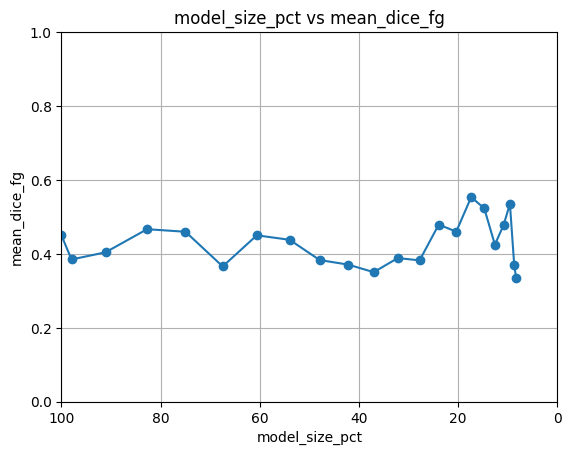

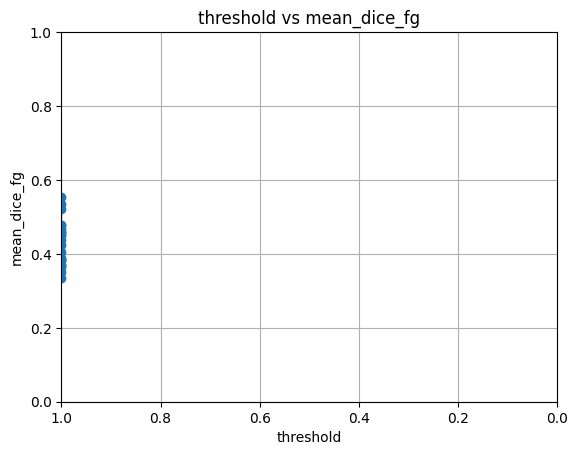

In [4]:
import matplotlib.pyplot as plt

def plot_df_xy(df, x_col, y_col):
    plt.figure()
    plt.plot(df[x_col], df[y_col], marker='o')
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.xlim(max(df[x_col]), 0)   
    plt.ylim(0, 1)     

    plt.grid(True)
    plt.show()


plot_df_xy(df, "model_size_pct", "mean_dice_fg")
plot_df_xy(df, "threshold", "mean_dice_fg")

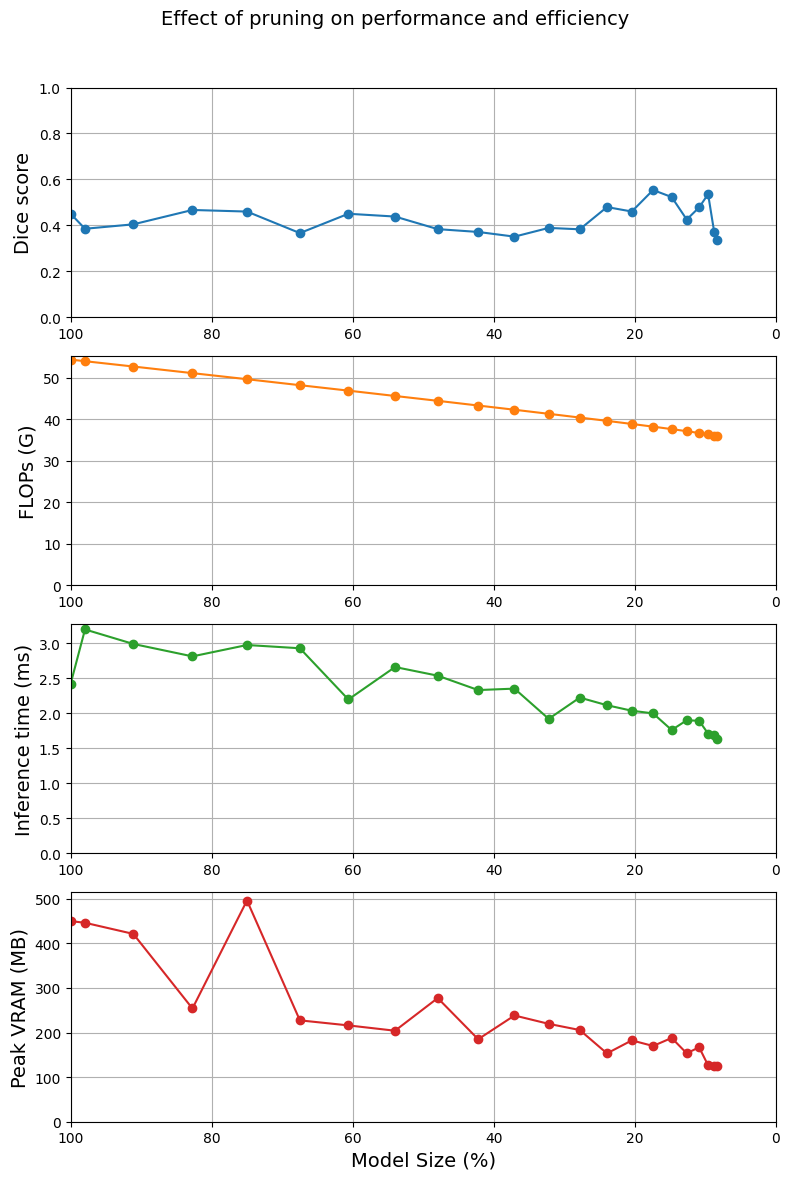

In [7]:
def plot_pruning_summary(df, x_col, y_col):

    plt.figure(figsize=(8, 12))
    fs = 14

    # 1. Dice
    plt.subplot(4, 1, 1)
    plt.plot(df[x_col], df[y_col[0]], marker="o", color="tab:blue")
    plt.ylabel("Dice score", fontsize=fs)
    plt.ylim(0, 1)
    plt.xlim(max(df[x_col]), 0) 
    plt.grid(True)

    # 2. FLOPs
    plt.subplot(4, 1, 2)
    plt.plot(df[x_col], df[y_col[1]], marker="o", color="tab:orange")
    plt.ylabel("FLOPs (G)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    # 3. Inference time
    plt.subplot(4, 1, 3)
    plt.plot(df[x_col], df[y_col[2]], marker="o", color="tab:green")
    plt.ylabel("Inference time (ms)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    # 4. VRAM
    plt.subplot(4, 1, 4)
    plt.plot(df[x_col], df[y_col[3]], marker="o", color="tab:red")
    plt.xlabel("Model Size (%)", fontsize=fs)
    plt.ylabel("Peak VRAM (MB)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    plt.suptitle("Effect of pruning on performance and efficiency", fontsize=fs)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



plot_pruning_summary(df, "model_size_pct", ["mean_dice_fg", "flops_g", "inference_ms", "vram_peak_mb"])


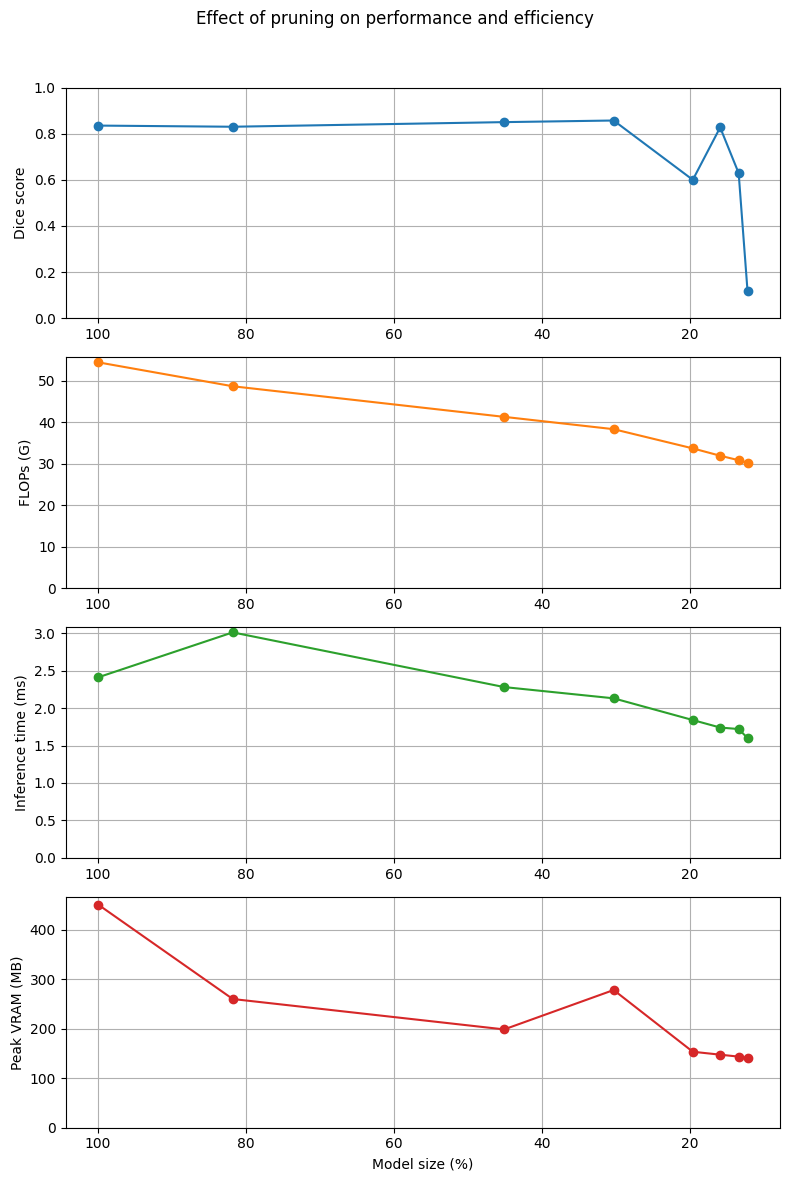

In [ ]:
import matplotlib.pyplot as plt

# Pruning percentages / model size (%)
# model_size = [100, 81.8, 45.1, 30.3, 19.6, 15.9, 13.4, 12.2]
#model_size = [100, 81.8, 45.1, 30.3, 19.6, 15.9, 13.4, 12.2]
num_params = [43.9, 34.4, 19.4]

# Metrics
dice = [0.835, 0.35, 0.29]
flops = [54.44, 48.68, 40.2]
inference = [2.41, 2.79, 2.21]
vram = [450.89, 389.0, 197.1]

# Taller figure
plt.figure(figsize=(8, 12))

# Dice
plt.subplot(4, 1, 1)
plt.plot(model_size, dice, marker='o', color='tab:blue')
plt.ylabel("Dice score")
plt.ylim(0, 1)
plt.gca().invert_xaxis()
plt.grid(True)

# FLOPs
plt.subplot(4, 1, 2)
plt.plot(model_size, flops, marker='o', color='tab:orange')
plt.ylabel("FLOPs (G)")
plt.ylim(bottom=0)
plt.gca().invert_xaxis()
plt.grid(True)

# Inference time
plt.subplot(4, 1, 3)
plt.plot(model_size, inference, marker='o', color='tab:green')
plt.ylabel("Inference time (ms)")
plt.ylim(bottom=0)
plt.gca().invert_xaxis()
plt.grid(True)

# VRAM
plt.subplot(4, 1, 4)
plt.plot(model_size, vram, marker='o', color='tab:red')
plt.xlabel("Model size (%)")
plt.ylabel("Peak VRAM (MB)")
plt.ylim(bottom=0)
plt.gca().invert_xaxis()
plt.grid(True)

plt.suptitle("Effect of pruning on performance and efficiency on STONE dataset")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
